In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [13]:
import SoccerNet
from SoccerNet.Downloader import SoccerNetDownloader
import os
import numpy as np
import pandas as pd
from IPython.display import Image
import cv2
from glob import glob
import re
import yaml
from tqdm.notebook import tqdm

In [14]:
yolo_base = '/home/bowen/Code/soccer/yolov7'
sn_track_base = '/home/bowen/Code/soccer/data/tracking'
!nvidia-smi

Tue Dec  6 17:34:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.11    Driver Version: 525.60.11    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8     7W /  N/A |    612MiB /  8192MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
trn_dirs = sorted(glob(f'{sn_track_base}/train/SNMOT*'))
tst_dirs = sorted(glob(f'{sn_track_base}/test/SNMOT*'))

# debug=True
# if debug:
#     trn_dirs = trn_dirs[:5]
#     tst_dirs = tst_dirs[:]

split_dirs = {
    'train':trn_dirs,
    'valid':tst_dirs
}

labels = ['ball', 'player', 'referee', 'goalkeepers']
label_dict = {'ball': 0, 'player': 1, 'referee': 2, 'goalkeeper': 3, 'goalkeepers': 3}

# labels = ['ball', 'player team left', 'player team right', 'referee', 'goalkeepers']
# label_dict = {'ball': 0, 'player team left': 1, 'player team right': 2, 'referee': 3, 'goalkeeper': 4, 'goalkeepers': 4}

In [16]:
#(1) image file path
yolo_train_img_dir = f'{yolo_base}/images/train'
yolo_valid_img_dir = f'{yolo_base}/images/valid'

#(2) label file path
yolo_train_label_dir = f'{yolo_base}/labels/train'
yolo_valid_label_dir = f'{yolo_base}/labels/valid'

#(3) config file path
yaml_file = f'{yolo_base}/data.yaml'

os.makedirs(yolo_train_img_dir, exist_ok=True)
os.makedirs(yolo_valid_img_dir, exist_ok=True)
os.makedirs(yolo_train_label_dir, exist_ok=True)
os.makedirs(yolo_valid_label_dir, exist_ok=True)

In [17]:
# convert from x,y,w,h to yolo format
def get_yolo_format_bbox(img_w, img_h, box):
  w = box[2]
  h = box[3]
  xc = box[0] + int(np.round(w/2))
  yc = box[1] + int(np.round(h/2))
  box = [xc/img_w, yc/img_h, w/img_w, h/img_h]
  box = [f"{i:.4g}" for i in box]
  return box
    
# get SoccerNet label info 
def get_info(info):
  results = []
  for line in open(info):
    m = re.match('trackletID_(\d+)= (\S*).*', line.replace(';', ' '))
    if m:
      # print(m, m.group(2))
      if m.group(2) not in label_dict:
        print('bad label:', m.group(2))
        continue 
      results.append([m.group(1), m.group(2)])
  return pd.DataFrame(results, columns=['id','lbl']).set_index('id').to_dict()['lbl']

# make image simlink and label files
for split in tqdm(split_dirs):
  if split == 'train':
    yolo_img_dir = yolo_train_img_dir
    yolo_label_dir = yolo_train_label_dir
  else:
    yolo_img_dir = yolo_valid_img_dir
    yolo_label_dir = yolo_valid_label_dir
      
  for this_dir in split_dirs[split]:
    print('this_dir:',this_dir)
    video = this_dir.split('/')[-1]
    info = this_dir + '/gameinfo.ini'
    det = this_dir + '/gt/gt.txt'
    info_dict = get_info(info)
    det_df = pd.read_csv(det, names=['frame','player','x','y','w','h','f1','f2','f3','f4'], usecols=['frame','player','x','y','w','h'])
    det_df['label'] = det_df.player.astype(str).map(info_dict)
    det_df['label_id'] = det_df['label'].map(label_dict)

    # check
    ng_list = list(det_df[det_df.label_id.isnull()].label.unique())
    if len(ng_list)>0:
      #print('ng_list:',ng_list, det_df.dropna().shape, det_df.shape)
      det_df = det_df.dropna()
    for grp, grp_df in det_df.groupby('frame'):
      frame = f'{grp:06}'
      img_file = f'{this_dir}/img1/{frame}.jpg'
      dst_file = f'{yolo_img_dir}/{video}_{frame}.jpg'
      if not os.path.exists(dst_file):
        os.symlink(img_file, dst_file)
        #print(img_file)
      img = cv2.imread(dst_file)
      height, width, _ = img.shape 
      bboxes = []
      for arr in grp_df[['x', 'y', 'w', 'h', 'label_id']].values:
        box = get_yolo_format_bbox(width, height, arr[:4])
        bboxes.append([arr[4]]+box)
      file_name = f'{yolo_label_dir}/{video}_{frame}.txt'
      with open(file_name, 'w') as f:
        for i, bbox in enumerate(bboxes):
          bbox = [str(i) for i in bbox]
          str_bbox = ' '.join(bbox)
          f.write(str_bbox)
          f.write('\n')

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [7]:
# Dump config file
data_yaml = dict(
    train = yolo_train_img_dir,
    val = yolo_valid_img_dir,
    nc = 4,
    names = labels
)

with open(yaml_file, 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

In [8]:
!nvidia-smi
!nvcc -V

Tue Dec  6 17:23:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.11    Driver Version: 525.60.11    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8     7W /  N/A |    886MiB /  8192MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
# train!
!cd $yolo_base && time python train_aux.py \
    --workers 16 \
    --batch-size 2 \
    --data data.yaml \
    --img 768 \
    --epochs 15 \
    --cfg cfg/training/yolov7-w6.yaml \
    --weights yolov7-w6_training.pt \
    --name yolov7-w6-custom \
    --hyp data/hyp.scratch.custom.yaml

YOLOR 🚀 v0.1-116-g8c0bf3f torch 1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 7974.375MB)

Namespace(weights='yolov7-w6_training.pt', cfg='cfg/training/yolov7-w6.yaml', data='data.yaml', hyp='data/hyp.scratch.custom.yaml', epochs=1, batch_size=3, img_size=[768, 768], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=16, project='runs/train', entity=None, name='yolov7-w6-custom', exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias='latest', v5_metric=False, world_size=1, global_rank=-1, save_dir='runs/train/yolov7-w6-custom', total_batch_size=3)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2022-12-06 17:25:35.346257: I tensorflow/core/platform/cpu_feature_g

 51          [-1, -2]  1         0  models.common.Concat                    [1]                           
 52                -1  1    295680  models.common.Conv                      [768, 384, 1, 1]              
 53                -2  1    295680  models.common.Conv                      [768, 384, 1, 1]              
 54                -1  1    663936  models.common.Conv                      [384, 192, 3, 1]              
 55                -1  1    332160  models.common.Conv                      [192, 192, 3, 1]              
 56                -1  1    332160  models.common.Conv                      [192, 192, 3, 1]              
 57                -1  1    332160  models.common.Conv                      [192, 192, 3, 1]              
 58[-1, -2, -3, -4, -5, -6]  1         0  models.common.Concat                    [1]                           
 59                -1  1    590592  models.common.Conv                      [1536, 384, 1, 1]             
 60                -1  1     98

val: Scanning '/home/bowen/Code/soccer/yolov7/labels/valid.cache' images and lab

autoanchor: Analyzing anchors... anchors/target = 3.06, Best Possible Recall (BPR) = 0.9472. Attempting to improve anchors, please wait...
autoanchor: WARNING: Extremely small objects found. 222 of 66560 labels are < 3 pixels in size.
autoanchor: Running kmeans for 12 anchors on 66560 points...
autoanchor: thr=0.25: 0.9998 best possible recall, 10.29 anchors past thr
autoanchor: n=12, img_size=768, metric_all=0.546/0.876-mean/best, past_thr=0.613-mean: 5,5,  9,21,  13,27,  13,35,  19,33,  16,44,  21,42,  26,37,  23,52,  32,47,  30,64,  44,61
autoanchor: Evolving anchors with Genetic Algorithm: fitness = 0.8799: 100%|█| 1
autoanchor: thr=0.25: 0.9998 best possible recall, 10.29 anchors past thr
autoanchor: n=12, img_size=768, metric_all=0.554/0.880-mean/best, past_thr=0.623-mean: 5,5,  9,21,  12,27,  14,34,  18,32,  16,41,  19,43,  24,39,  23,49,  31,45,  29,60,  42,60
autoanchor: New anchors saved to mode

In [12]:
!nvidia-smi

Tue Dec  6 17:33:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.11    Driver Version: 525.60.11    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   59C    P8     8W /  N/A |    898MiB /  8192MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
# predict!
check_images = f'{tst_dirs[0]}/img1'
weight_file = 'runs/train/yolov7-w6-custom14/weights/best.pt'
!cd $yolo_base && python detect.py \
    --weights $weight_file \
    --source  $check_images \
    --img-size 768 \
    --project dfl

Namespace(weights=['runs/train/yolov7-w6-custom14/weights/best.pt'], source='/home/bowen/Code/soccer/data/tracking/test/SNMOT-116/img1', img_size=768, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='dfl', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-116-g8c0bf3f torch 1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 7974.375MB)

Fusing layers... 
IAuxDetect.fuse
Model Summary: 370 layers, 80961284 parameters, 0 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/home/bowen/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
13 players, 

 The image with the result is saved in: dfl/exp/000054.jpg
12 players, 2 referees, 3 goalkeeperss, Done. (12.2ms) Inference, (1.2ms) NMS
 The image with the result is saved in: dfl/exp/000055.jpg
13 players, 2 referees, 4 goalkeeperss, Done. (12.6ms) Inference, (0.7ms) NMS
 The image with the result is saved in: dfl/exp/000056.jpg
13 players, 2 referees, 3 goalkeeperss, Done. (13.8ms) Inference, (0.8ms) NMS
 The image with the result is saved in: dfl/exp/000057.jpg
15 players, 2 referees, 3 goalkeeperss, Done. (13.6ms) Inference, (2.2ms) NMS
 The image with the result is saved in: dfl/exp/000058.jpg
16 players, 2 referees, 3 goalkeeperss, Done. (12.1ms) Inference, (1.1ms) NMS
 The image with the result is saved in: dfl/exp/000059.jpg
14 players, 2 referees, 3 goalkeeperss, Done. (12.9ms) Inference, (1.2ms) NMS
 The image with the result is saved in: dfl/exp/000060.jpg
14 players, 2 referees, 3 goalkeeperss, Done. (12.1ms) Inference, (1.1ms) NMS
 The image with the result is saved in: d

 The image with the result is saved in: dfl/exp/000115.jpg
13 players, 1 referee, 3 goalkeeperss, Done. (10.8ms) Inference, (0.7ms) NMS
 The image with the result is saved in: dfl/exp/000116.jpg
12 players, 1 referee, 3 goalkeeperss, Done. (11.4ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000117.jpg
13 players, 1 referee, 3 goalkeeperss, Done. (10.9ms) Inference, (0.7ms) NMS
 The image with the result is saved in: dfl/exp/000118.jpg
12 players, 1 referee, 3 goalkeeperss, Done. (10.8ms) Inference, (0.8ms) NMS
 The image with the result is saved in: dfl/exp/000119.jpg
12 players, 1 referee, 3 goalkeeperss, Done. (10.8ms) Inference, (0.7ms) NMS
 The image with the result is saved in: dfl/exp/000120.jpg
12 players, 1 referee, 3 goalkeeperss, Done. (13.3ms) Inference, (1.6ms) NMS
 The image with the result is saved in: dfl/exp/000121.jpg
11 players, 1 referee, 3 goalkeeperss, Done. (12.1ms) Inference, (1.3ms) NMS
 The image with the result is saved in: dfl/exp/

 The image with the result is saved in: dfl/exp/000176.jpg
16 players, 1 referee, 4 goalkeeperss, Done. (13.9ms) Inference, (1.0ms) NMS
 The image with the result is saved in: dfl/exp/000177.jpg
14 players, 1 referee, 4 goalkeeperss, Done. (12.2ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000178.jpg
13 players, 1 referee, 4 goalkeeperss, Done. (12.6ms) Inference, (0.8ms) NMS
 The image with the result is saved in: dfl/exp/000179.jpg
16 players, 1 referee, 5 goalkeeperss, Done. (12.0ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000180.jpg
16 players, 1 referee, 3 goalkeeperss, Done. (11.2ms) Inference, (0.7ms) NMS
 The image with the result is saved in: dfl/exp/000181.jpg
14 players, 1 referee, 5 goalkeeperss, Done. (10.8ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000182.jpg
16 players, 1 referee, 2 goalkeeperss, Done. (10.9ms) Inference, (0.8ms) NMS
 The image with the result is saved in: dfl/exp/

14 players, 2 referees, 4 goalkeeperss, Done. (19.7ms) Inference, (1.2ms) NMS
 The image with the result is saved in: dfl/exp/000239.jpg
13 players, 2 referees, 4 goalkeeperss, Done. (13.1ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000240.jpg
13 players, 3 referees, 6 goalkeeperss, Done. (12.4ms) Inference, (0.8ms) NMS
 The image with the result is saved in: dfl/exp/000241.jpg
15 players, 1 referee, 5 goalkeeperss, Done. (12.5ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000242.jpg
15 players, 3 goalkeeperss, Done. (11.2ms) Inference, (1.0ms) NMS
 The image with the result is saved in: dfl/exp/000243.jpg
16 players, 3 goalkeeperss, Done. (12.2ms) Inference, (0.8ms) NMS
 The image with the result is saved in: dfl/exp/000244.jpg
14 players, 4 goalkeeperss, Done. (13.8ms) Inference, (1.2ms) NMS
 The image with the result is saved in: dfl/exp/000245.jpg
13 players, 2 referees, 4 goalkeeperss, Done. (12.0ms) Inference, (0.9ms) NMS


 The image with the result is saved in: dfl/exp/000299.jpg
18 players, 1 referee, 5 goalkeeperss, Done. (12.7ms) Inference, (1.0ms) NMS
 The image with the result is saved in: dfl/exp/000300.jpg
16 players, 2 referees, 5 goalkeeperss, Done. (11.2ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000301.jpg
17 players, 2 referees, 4 goalkeeperss, Done. (11.2ms) Inference, (0.8ms) NMS
 The image with the result is saved in: dfl/exp/000302.jpg
17 players, 4 referees, 7 goalkeeperss, Done. (13.4ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000303.jpg
17 players, 2 referees, 6 goalkeeperss, Done. (11.8ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000304.jpg
17 players, 2 referees, 7 goalkeeperss, Done. (10.8ms) Inference, (0.8ms) NMS
 The image with the result is saved in: dfl/exp/000305.jpg
16 players, 1 referee, 7 goalkeeperss, Done. (10.8ms) Inference, (0.8ms) NMS
 The image with the result is saved in: dfl

15 players, 4 referees, 8 goalkeeperss, Done. (16.6ms) Inference, (1.3ms) NMS
 The image with the result is saved in: dfl/exp/000360.jpg
16 players, 2 referees, 7 goalkeeperss, Done. (15.1ms) Inference, (1.2ms) NMS
 The image with the result is saved in: dfl/exp/000361.jpg
15 players, 4 referees, 7 goalkeeperss, Done. (14.7ms) Inference, (1.0ms) NMS
 The image with the result is saved in: dfl/exp/000362.jpg
15 players, 3 referees, 9 goalkeeperss, Done. (15.3ms) Inference, (1.0ms) NMS
 The image with the result is saved in: dfl/exp/000363.jpg
15 players, 5 referees, 7 goalkeeperss, Done. (13.7ms) Inference, (0.8ms) NMS
 The image with the result is saved in: dfl/exp/000364.jpg
15 players, 5 referees, 8 goalkeeperss, Done. (14.1ms) Inference, (1.0ms) NMS
 The image with the result is saved in: dfl/exp/000365.jpg
14 players, 4 referees, 8 goalkeeperss, Done. (12.3ms) Inference, (1.0ms) NMS
 The image with the result is saved in: dfl/exp/000366.jpg
15 players, 4 referees, 8 goalkeeperss, D

11 players, 2 referees, 3 goalkeeperss, Done. (13.8ms) Inference, (1.3ms) NMS
 The image with the result is saved in: dfl/exp/000420.jpg
11 players, 3 referees, 5 goalkeeperss, Done. (14.0ms) Inference, (1.9ms) NMS
 The image with the result is saved in: dfl/exp/000421.jpg
10 players, 3 referees, 5 goalkeeperss, Done. (15.8ms) Inference, (1.1ms) NMS
 The image with the result is saved in: dfl/exp/000422.jpg
10 players, 3 referees, 4 goalkeeperss, Done. (15.8ms) Inference, (1.2ms) NMS
 The image with the result is saved in: dfl/exp/000423.jpg
11 players, 2 referees, 4 goalkeeperss, Done. (13.0ms) Inference, (2.7ms) NMS
 The image with the result is saved in: dfl/exp/000424.jpg
11 players, 3 referees, 4 goalkeeperss, Done. (13.4ms) Inference, (1.5ms) NMS
 The image with the result is saved in: dfl/exp/000425.jpg
11 players, 4 referees, 4 goalkeeperss, Done. (11.8ms) Inference, (1.0ms) NMS
 The image with the result is saved in: dfl/exp/000426.jpg
11 players, 3 referees, 4 goalkeeperss, D

 The image with the result is saved in: dfl/exp/000481.jpg
7 players, 1 referee, 2 goalkeeperss, Done. (15.7ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000482.jpg
7 players, 2 goalkeeperss, Done. (16.1ms) Inference, (0.8ms) NMS
 The image with the result is saved in: dfl/exp/000483.jpg
7 players, 2 goalkeeperss, Done. (15.5ms) Inference, (1.0ms) NMS
 The image with the result is saved in: dfl/exp/000484.jpg
7 players, 1 referee, 2 goalkeeperss, Done. (16.0ms) Inference, (0.8ms) NMS
 The image with the result is saved in: dfl/exp/000485.jpg
7 players, 1 referee, 2 goalkeeperss, Done. (16.4ms) Inference, (1.1ms) NMS
 The image with the result is saved in: dfl/exp/000486.jpg
7 players, 1 referee, 1 goalkeepers, Done. (15.8ms) Inference, (1.0ms) NMS
 The image with the result is saved in: dfl/exp/000487.jpg
6 players, 2 goalkeeperss, Done. (16.3ms) Inference, (0.8ms) NMS
 The image with the result is saved in: dfl/exp/000488.jpg
6 players, 1 goalkeepers, Done

7 players, 1 referee, 2 goalkeeperss, Done. (12.5ms) Inference, (1.4ms) NMS
 The image with the result is saved in: dfl/exp/000547.jpg
7 players, 1 goalkeepers, Done. (13.8ms) Inference, (1.5ms) NMS
 The image with the result is saved in: dfl/exp/000548.jpg
8 players, 1 goalkeepers, Done. (11.5ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000549.jpg
7 players, 1 goalkeepers, Done. (11.7ms) Inference, (1.1ms) NMS
 The image with the result is saved in: dfl/exp/000550.jpg
7 players, 1 goalkeepers, Done. (11.2ms) Inference, (0.8ms) NMS
 The image with the result is saved in: dfl/exp/000551.jpg
7 players, 1 goalkeepers, Done. (14.1ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000552.jpg
7 players, 1 referee, Done. (13.4ms) Inference, (1.0ms) NMS
 The image with the result is saved in: dfl/exp/000553.jpg
6 players, Done. (14.9ms) Inference, (1.1ms) NMS
 The image with the result is saved in: dfl/exp/000554.jpg
6 players, Done. (12.0m

9 players, 1 referee, 3 goalkeeperss, Done. (13.1ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000612.jpg
8 players, 1 referee, 4 goalkeeperss, Done. (12.4ms) Inference, (1.5ms) NMS
 The image with the result is saved in: dfl/exp/000613.jpg
8 players, 1 referee, 3 goalkeeperss, Done. (14.4ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000614.jpg
8 players, 1 referee, 3 goalkeeperss, Done. (11.6ms) Inference, (1.0ms) NMS
 The image with the result is saved in: dfl/exp/000615.jpg
9 players, 1 referee, 3 goalkeeperss, Done. (10.9ms) Inference, (1.0ms) NMS
 The image with the result is saved in: dfl/exp/000616.jpg
9 players, 2 referees, 3 goalkeeperss, Done. (11.6ms) Inference, (1.4ms) NMS
 The image with the result is saved in: dfl/exp/000617.jpg
10 players, 1 referee, 3 goalkeeperss, Done. (12.6ms) Inference, (1.9ms) NMS
 The image with the result is saved in: dfl/exp/000618.jpg
10 players, 1 referee, 2 goalkeeperss, Done. (13.2ms)

10 players, 5 referees, 5 goalkeeperss, Done. (12.1ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000672.jpg
11 players, 5 referees, 6 goalkeeperss, Done. (11.0ms) Inference, (0.7ms) NMS
 The image with the result is saved in: dfl/exp/000673.jpg
1 ball, 12 players, 6 referees, 5 goalkeeperss, Done. (13.1ms) Inference, (1.3ms) NMS
 The image with the result is saved in: dfl/exp/000674.jpg
1 ball, 11 players, 5 referees, 6 goalkeeperss, Done. (13.6ms) Inference, (1.3ms) NMS
 The image with the result is saved in: dfl/exp/000675.jpg
12 players, 4 referees, 5 goalkeeperss, Done. (12.9ms) Inference, (1.2ms) NMS
 The image with the result is saved in: dfl/exp/000676.jpg
10 players, 5 referees, 4 goalkeeperss, Done. (11.4ms) Inference, (0.8ms) NMS
 The image with the result is saved in: dfl/exp/000677.jpg
1 ball, 12 players, 4 referees, 3 goalkeeperss, Done. (12.4ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000678.jpg
11 players, 4 ref

12 players, 3 referees, 6 goalkeeperss, Done. (14.9ms) Inference, (1.0ms) NMS
 The image with the result is saved in: dfl/exp/000732.jpg
13 players, 3 referees, 6 goalkeeperss, Done. (15.3ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000733.jpg
11 players, 4 referees, 6 goalkeeperss, Done. (15.2ms) Inference, (0.9ms) NMS
 The image with the result is saved in: dfl/exp/000734.jpg
12 players, 2 referees, 6 goalkeeperss, Done. (16.0ms) Inference, (2.0ms) NMS
 The image with the result is saved in: dfl/exp/000735.jpg
13 players, 3 referees, 4 goalkeeperss, Done. (15.0ms) Inference, (1.3ms) NMS
 The image with the result is saved in: dfl/exp/000736.jpg
14 players, 3 referees, 5 goalkeeperss, Done. (15.7ms) Inference, (1.1ms) NMS
 The image with the result is saved in: dfl/exp/000737.jpg
15 players, 3 referees, 5 goalkeeperss, Done. (15.4ms) Inference, (0.8ms) NMS
 The image with the result is saved in: dfl/exp/000738.jpg
1 ball, 15 players, 3 referees, 6 goalkee

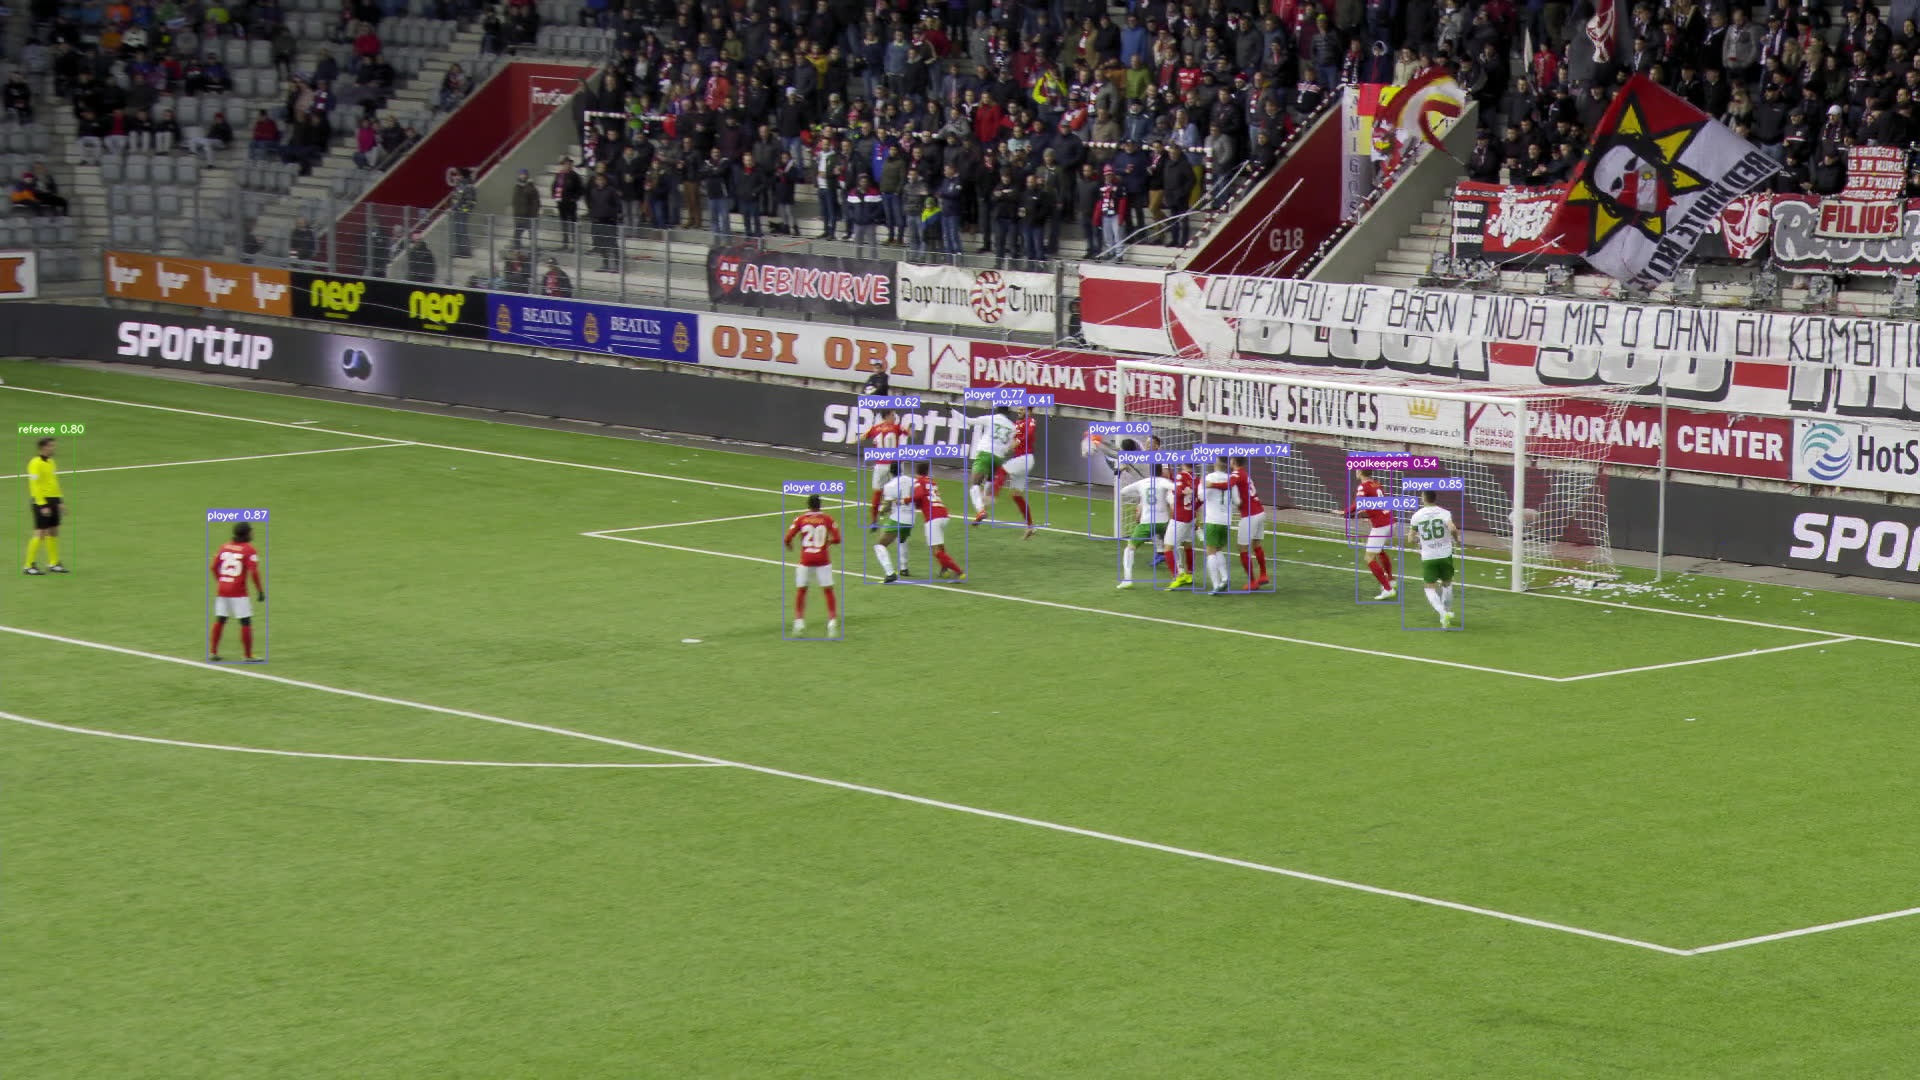

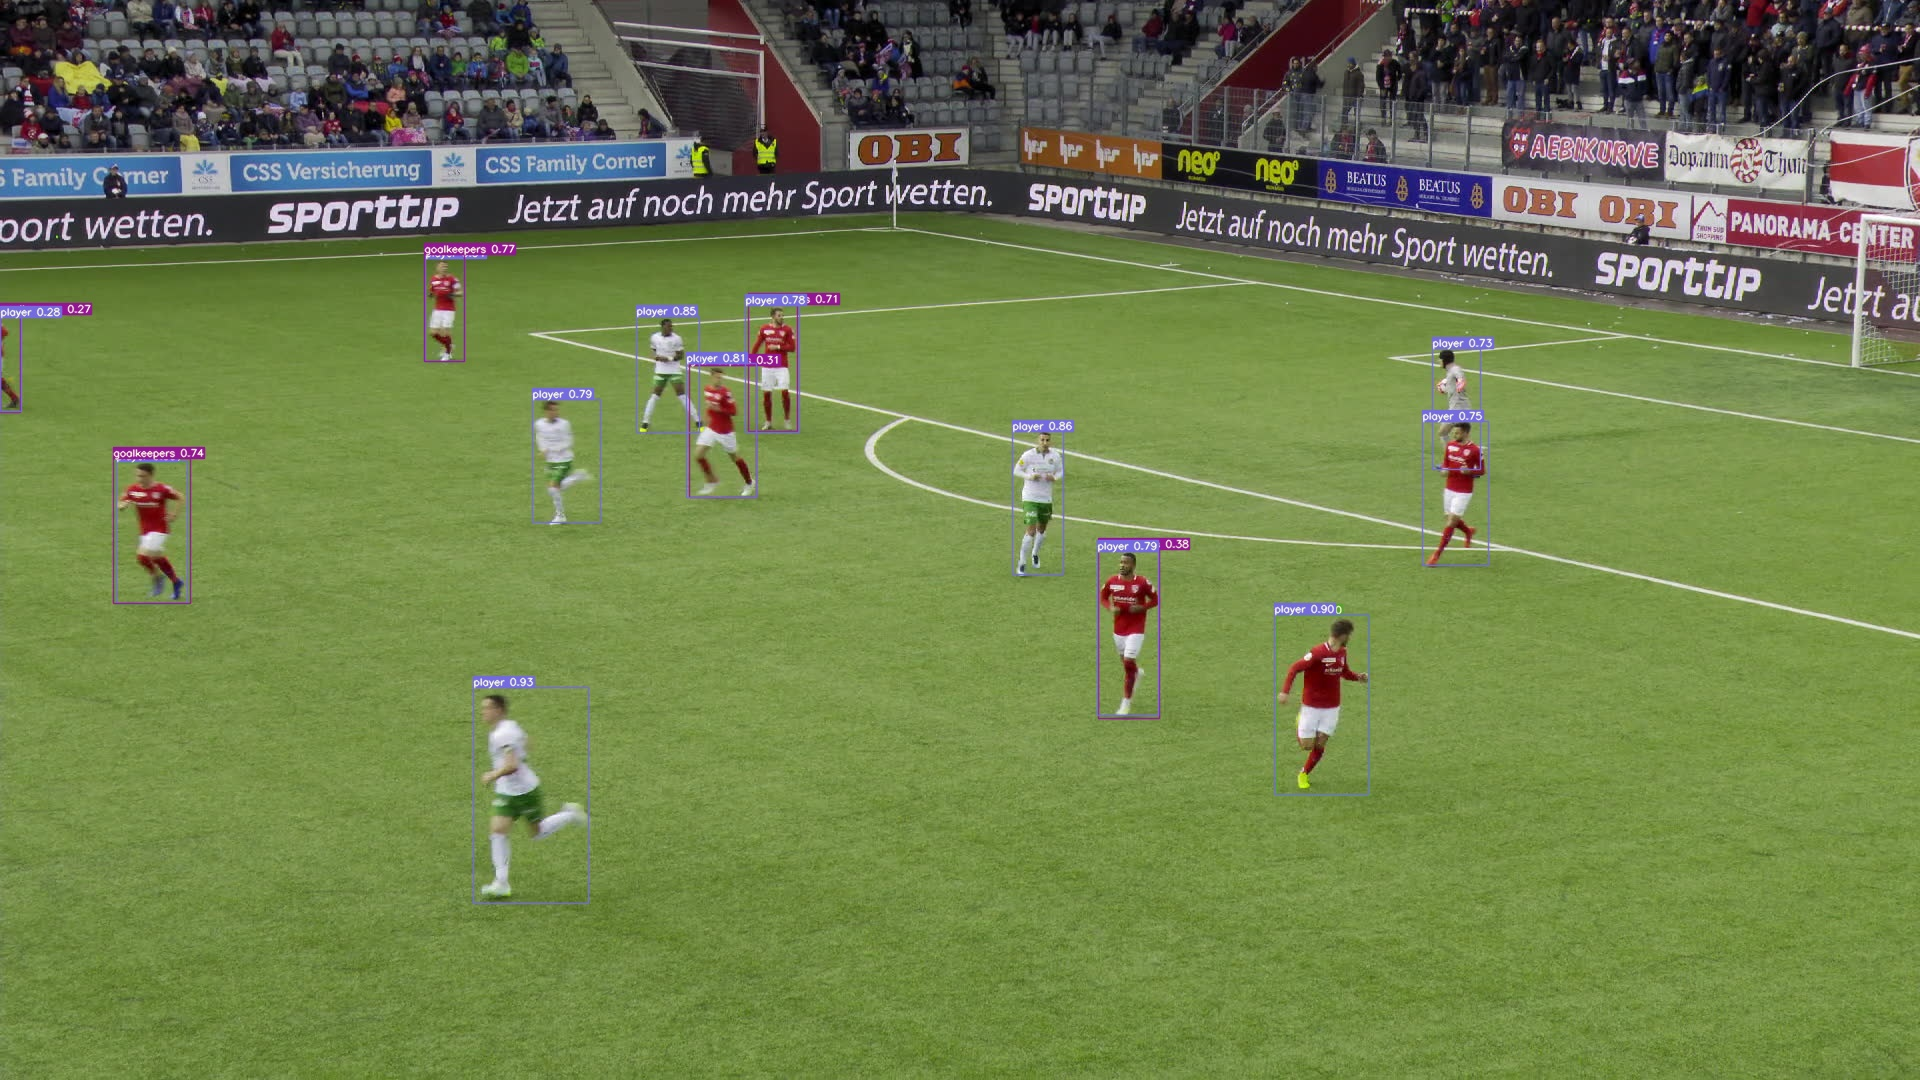

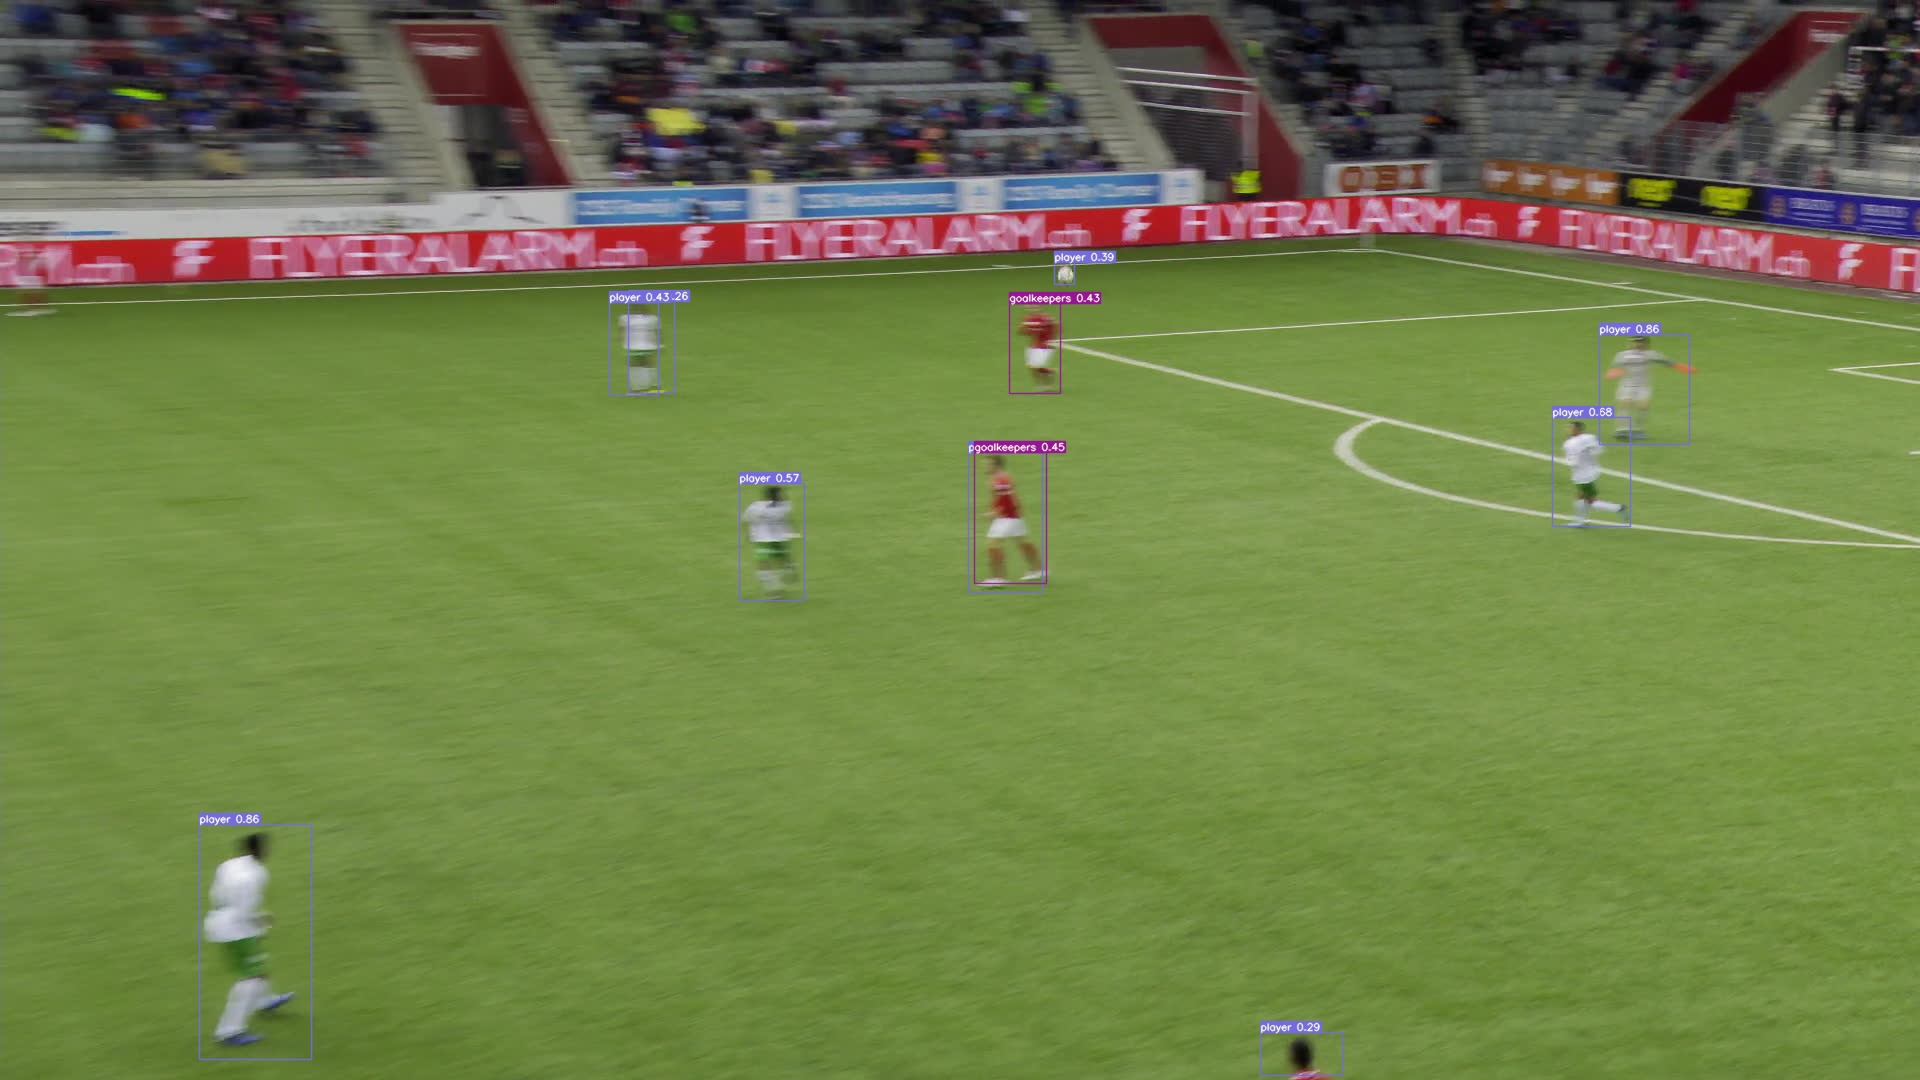

In [10]:
# Check some results. 
display(Image(f'{yolo_base}/dfl/exp/000200.jpg'))
display(Image(f'{yolo_base}/dfl/exp/000400.jpg'))
display(Image(f'{yolo_base}/dfl/exp/000600.jpg'))